In [1]:
from sdof_pinn import bbnn, sdof_pinn, normalise, ParamClipper
from sdof_oscillators import sdof_solution, add_noise, generate_excitation

import numpy as np
import torch
import torch.nn as nn

from tqdm import tqdm
from tqdm.auto import tqdm as tqdma

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
plt.rcParams.update({
    'text.usetex' : True,
    'mathtext.fontset' : 'stix',
    'font.family' : 'STIXGeneral'
})

%load_ext autoreload
%autoreload 2

In [2]:
result_data_pg = torch.load('results/sdof_forced_cubic_pg.pth')
result_data_bb = torch.load('results/sdof_forced_cubic_bb.pth')
results = {
    "bb" : result_data_bb,
    "pg" : result_data_pg
}

Case: bb
Predicted c: 1.0000
Predicted k: 15.0000
Predicted k_3: 100.0000
Case: pg
Predicted c: 1.0000
Predicted k: 15.0000
Predicted k_3: 100.0000


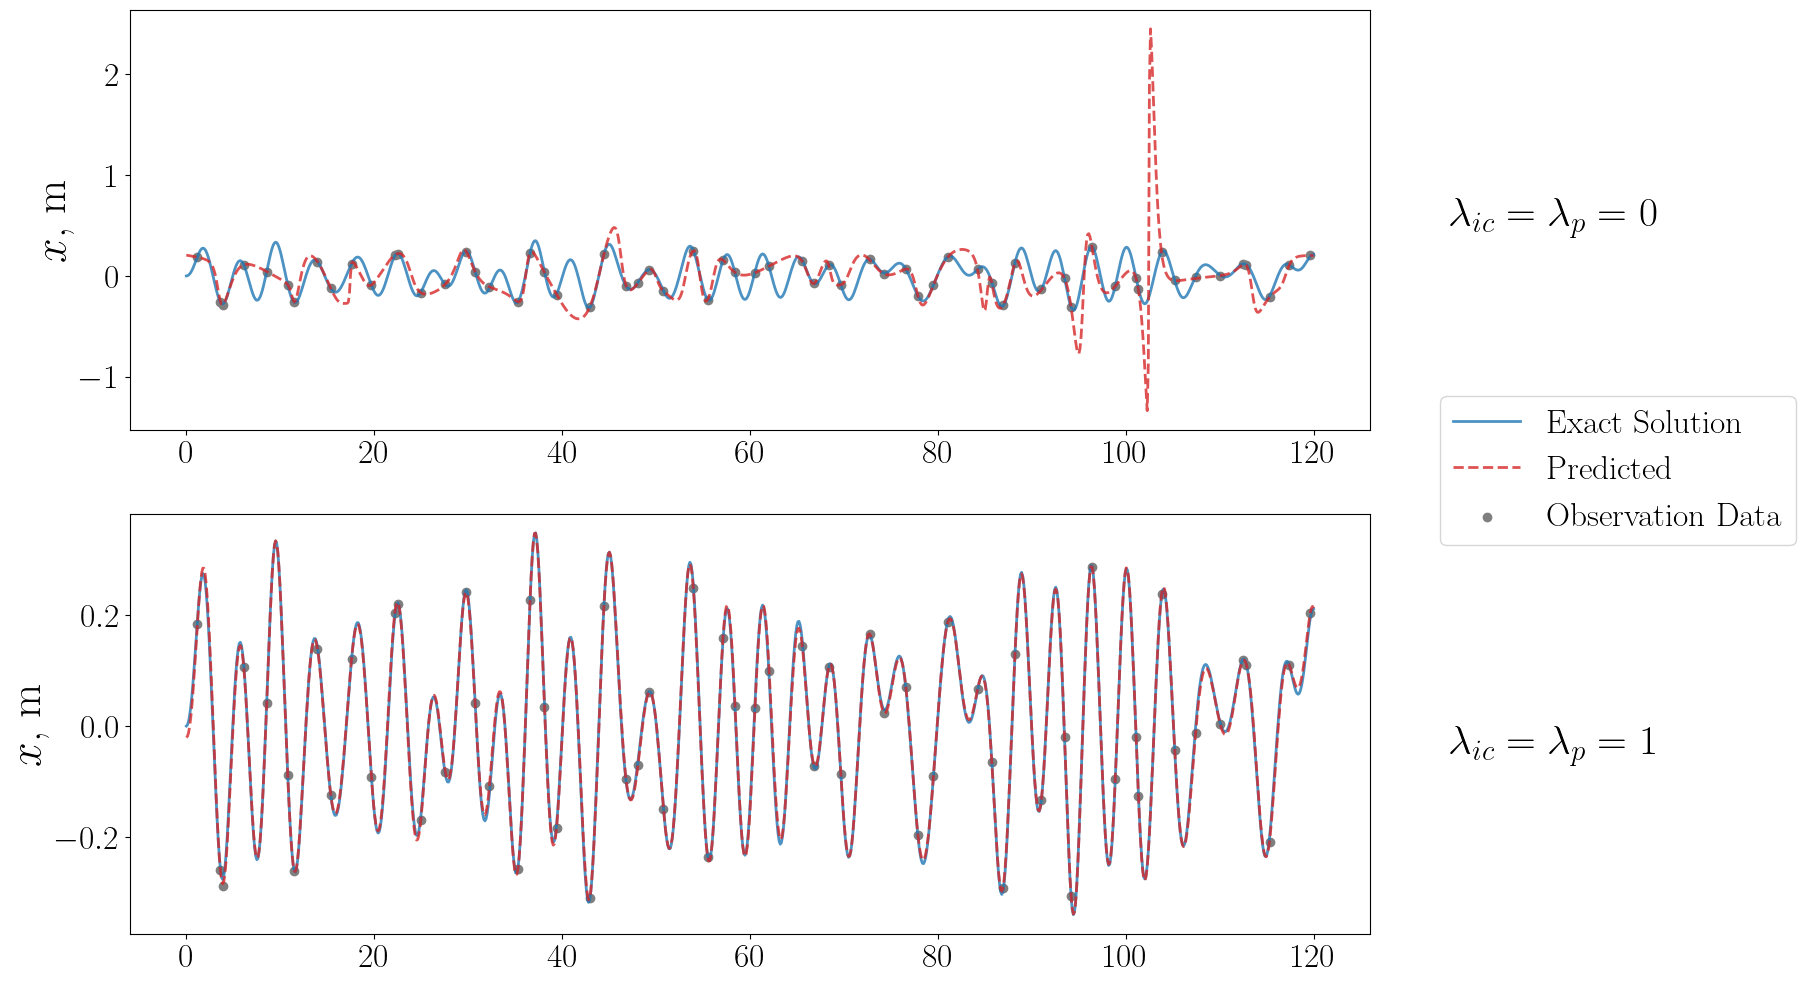

In [30]:
x_gt = [None] * 2
x_pred = [None] * 2
fig, axs = plt.subplots(2,1,figsize=(16,12))
labels = [
    "$\lambda_{ic}=\lambda_{p}=0$",
    "$\lambda_{ic}=\lambda_{p}=1$"
]

for i, (linearity, result_data) in enumerate(results.items()):
    gt_config = result_data["gt_config"]
    pinn_config = result_data["osa_config"]
    model_dict = result_data["model"]
    loss_hist = result_data["loss"]
    ground_truth = result_data["ground_truth"]
    data = result_data["data"]
    prediction = result_data["prediction"]
    alphas = result_data["alphas"]

    pi_model = sdof_pinn(
        N_INPUT = 1,
        N_OUTPUT = 1,
        N_HIDDEN = 32,
        N_LAYERS = 4
        )
    pi_model.configure(**pinn_config)
    pi_model.load_state_dict(model_dict)

    # ground truths
    t = ground_truth["t_hat"] * alphas["t"]
    x_gt = ground_truth["x_hat"] * alphas["x"]
    f_gt = pi_model.force * alphas["F"]
    m = 10.0
    c_ = gt_config["params"]["c_tild"] * m
    k_ = gt_config["params"]["k_tild"] * m
    if linearity == "nonlinear":
        k_3_ = gt_config["params"]["k3_tild"] * m

    # training data
    t_data = data["t_hat"] * alphas["t"]
    x_data = data["x_hat"] * alphas["x"]

    # predictions
    # x_pred = prediction["x_hat"] * alphas["x"]
    x_pred = pi_model(t/alphas["t"]).detach() * alphas["x"]
    c_pred = pi_model.phys_params[0] * m
    k_pred = pi_model.phys_params[1] * m
    k3_pred = pi_model.phys_params[2] * m
    print("Case: %s\nPredicted c: %.4f\nPredicted k: %.4f\nPredicted k_3: %.4f" % (linearity, c_pred, k_pred, k3_pred))

    axs[i].plot(t, x_gt, color="tab:blue", linewidth=2, alpha=0.8, label="Exact Solution")
    axs[i].plot(t, x_pred, color="tab:red", linestyle='--', linewidth=2, alpha=0.8, label="Predicted")
    axs[i].scatter(t_data, x_data, marker="o", s=36, color="tab:gray", label="Observation Data")
    axs[i].set_ylabel("$x$, m", fontsize=32)
    # axs[0].set_xlabel("Time, s", fontsize=36)
    axs[i].tick_params(axis='both', which='major', labelsize=24)
    axs[0].legend(fontsize=24, loc='upper center', bbox_to_anchor=(1.2, 0.12))
    axs[i].text(0.95, 0.7-0.44*i, labels[i], fontsize=30, transform=plt.gcf().transFigure)

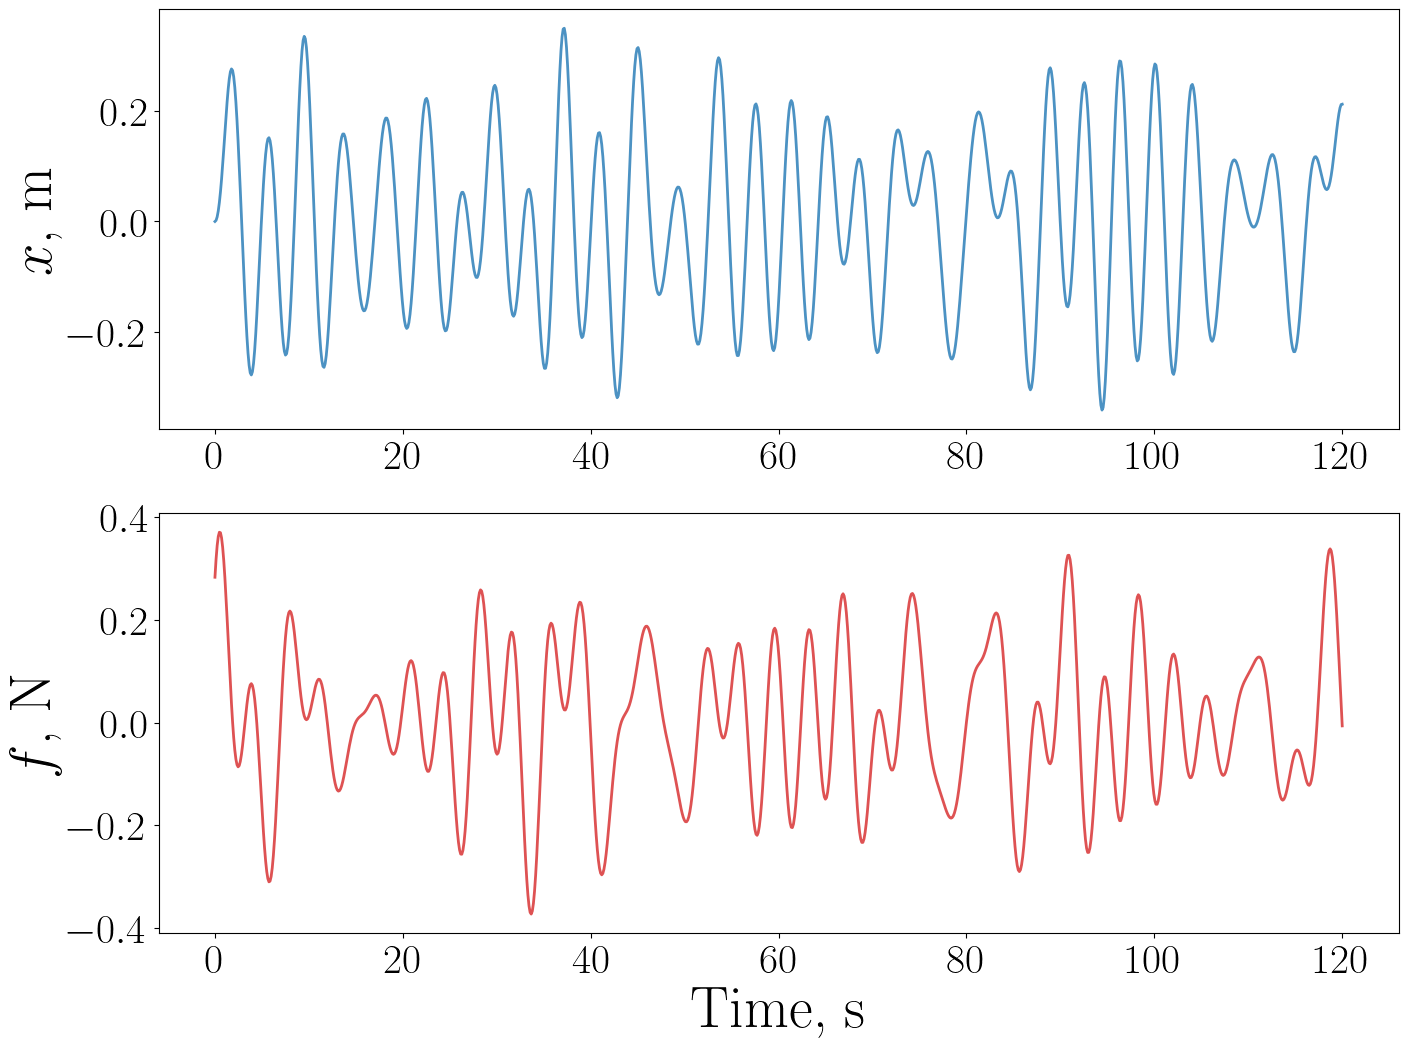

In [21]:
fig, axs = plt.subplots(2,1,figsize=(16,12))
axs[0].plot(t, x_gt, color="tab:blue", linewidth=2, alpha=0.8, label="Displacement")
axs[0].set_ylabel("$x$, m", fontsize=42)
# axs[0].set_xlabel("Time, s", fontsize=36)
axs[0].tick_params(axis='both', which='major', labelsize=30)
# axs[0].legend(fontsize=20, loc='lower center')

axs[1].plot(t, f_gt.detach(), color="tab:red", linewidth=2, alpha=0.8, label="Forcing Signal")
axs[1].set_ylabel("$f$, N", fontsize=42)
axs[1].set_xlabel("Time, s", fontsize=42)
axs[1].tick_params(axis='both', which='major', labelsize=30)
# axs[1].legend(fontsize=20, loc='lower center')

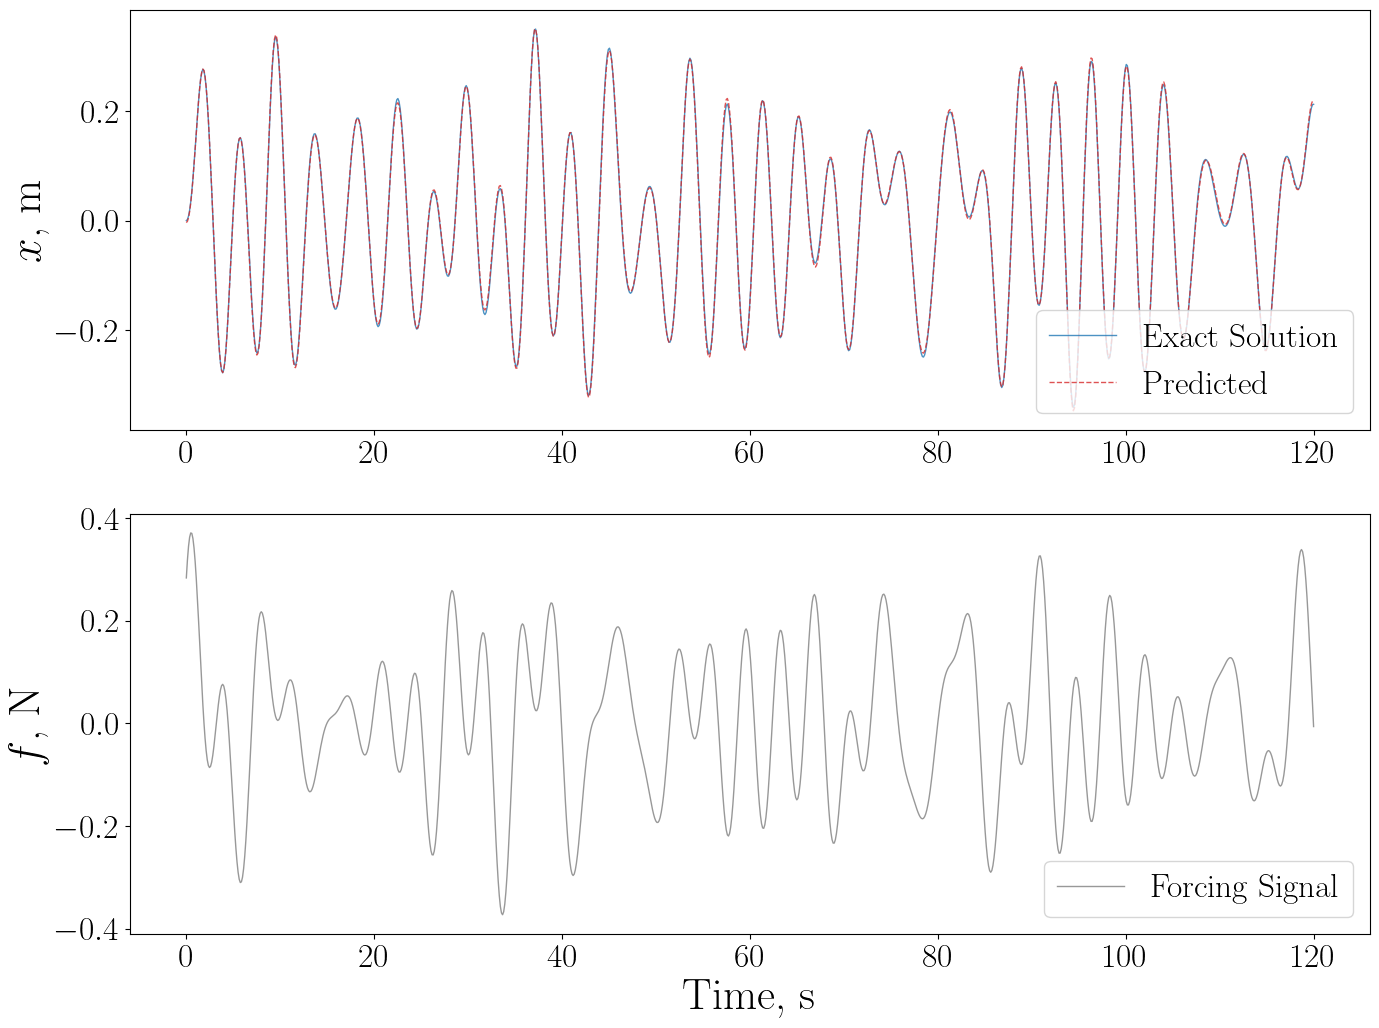

In [17]:
# equation discovery results

fig, axs = plt.subplots(2,1,figsize=(16,12))
axs[0].plot(t, x_gt, color="tab:blue", linewidth=1, alpha=0.8, label="Exact Solution")
axs[0].plot(t, x_pred, color="tab:red", linestyle='--', linewidth=1, alpha=0.8, label="Predicted")
axs[0].set_ylabel("$x$, m", fontsize=32)
# axs[0].set_xlabel("Time, s", fontsize=36)
axs[0].tick_params(axis='both', which='major', labelsize=24)
axs[0].legend(fontsize=24, loc='lower right')

axs[1].plot(t, f_gt.detach(), color="tab:gray", linewidth=1, alpha=0.8, label="Forcing Signal")
axs[1].set_ylabel("$f$, N", fontsize=32)
axs[1].set_xlabel("Time, s", fontsize=32)
axs[1].tick_params(axis='both', which='major', labelsize=24)
axs[1].legend(fontsize=24, loc='lower right')

In [ ]:
nt = 1024
t = np.linspace(0,120,nt)

F0 = 0.1  # N

# excitation = {
#     "type" : "sinusoid",
#     "F0" : F0,
#     "w" : 1.6  # rad/s
# }

excitation = {
    "type" : "rand_phase_ms",
    "F0" : F0,
    "freqs" :   np.array([0.7, 0.85, 1.6, 1.8]),
    "Sx" :      np.array([1.0, 1.0, 1.0, 1.0])
}

# excitation = {
#     "type" : "white_gaussian",
#     "F0" : F0,
#     "offset" :   0.0
# }

# excitation = {
#     "type" : "sine_sweep",
#     "F0" : F0,
#     "w" :   np.array([0.4, 2.8]),
#     "scale" :  "linear"
# }

F = generate_excitation(t, **excitation)
excitation["F"] = F.reshape(-1)

### Generate training and ground truth
m = 10.0
c = 1.0
k = 15.0
k3 = 100.0
excitation["F_tild"] = excitation["F"]/m

wn = np.sqrt(k/m)
zeta = c/(2*m*wn)
wd = wn*np.sqrt(1-zeta**2)

k_tild = k/m
c_tild = c/m
k3_tild = k3/m

gt_config = {
    "nonlinearity" : "cubic",
    # "m_norm" : False,
    # "params" : {
    #     "m" : m,
    #     "k" : k,
    #     "c" : c,
    #     "k3" : k3
    # },
    "m_norm" : True,
    "params" : {
        "k_tild" : k_tild,
        "c_tild" : c_tild,
        "k3_tild" : k3_tild
    },
    "init_conds" : {
        "x0" : 0.0,
        "v0" : 0.0
    },
    "forcing" : excitation
}

x, v = sdof_solution(t, **gt_config)
x_noisy = add_noise(x.view(-1,1), 0.02)
t = torch.tensor(t).view(-1,1).to(torch.float32)

# slice out a number of points from the start of the signal
sub_ind = np.arange(0, int(nt/1), 4)

t_data = t[sub_ind]
x_data = x_noisy[sub_ind]

fig, axs= plt.subplots(2,1)
axs[0].plot(t, x_noisy, color="gray", label="Noisy data")
axs[0].plot(t, x, label="Exact solution")
axs[0].scatter(t_data, x_data, color="tab:orange", label="Training data")
axs[0].legend()

axs[1].plot(t, excitation["F_tild"], color="red", label="Forcing")
axs[1].legend()